In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from dtk.bicycle import benchmark_state_space_vs_speed, benchmark_matrices
import control

import plot_sim as ps

#%matplotlib notebook
#DEFAULT_FIGSIZE = (8, 6)
%matplotlib inline 
DEFAULT_FIGSIZE = (12, 8)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

In [2]:
def rudinshapiro(N):
    """
    Return first N terms of Rudin-Shapiro sequence
    https://en.wikipedia.org/wiki/Rudin-Shapiro_sequence
    Confirmed correct output to N = 10000:
    https://oeis.org/A020985/b020985.txt
    """
    def hamming(x):
        """
        Hamming weight of a binary sequence
        http://stackoverflow.com/a/407758/125507
        """
        return bin(x).count('1')

    out = np.empty(N, dtype=int)
    for n in range(N):
        b = hamming(n << 1 & n)
        a = (-1)**b
        out[n] = a

    return out

s = rudinshapiro(10)
print(s)
np.array(s > 0).astype(float) * np.pi

[ 1  1  1 -1  1  1 -1  1  1  1]


array([ 3.14159265,  3.14159265,  3.14159265,  0.        ,  3.14159265,
        3.14159265,  0.        ,  3.14159265,  3.14159265,  3.14159265])

dt =  0.001
length 24
frequencies 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8
rs sequence 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0


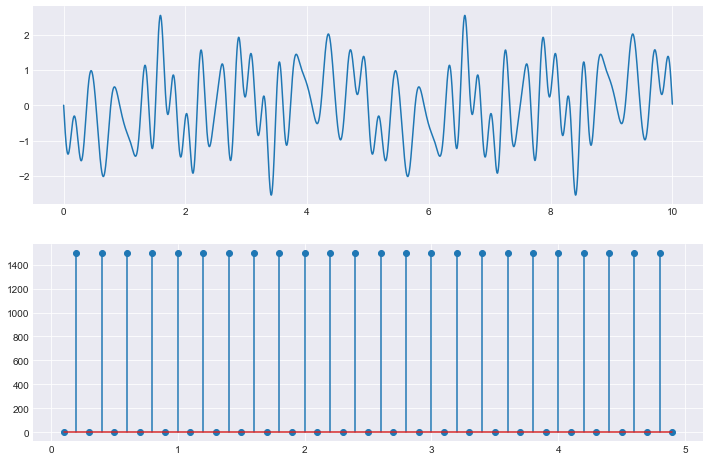

In [3]:
plt.close('all')

t = np.arange(0, 10, 0.001)
print('dt = ', t[1] - t[0])

def multisine(frequencies):
    n = len(frequencies)
    seq = np.array(rudinshapiro(n) > 0).astype(float)
    print('length', n)
    print('frequencies', ', '.join(str(f) for f in frequencies))
    print('rs sequence', ', '.join(str(s) for s in seq))
    
    u = np.zeros(t.shape)
    amplitude = 0.3
    for f, s in zip(frequencies, seq):
        u += amplitude*np.sin(2*np.pi*f*t + s*np.pi)
    return u

u_freq = np.arange(0.2, 5, 0.2)
u = multisine(u_freq)
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, u)

x = np.fft.fft(u)
freq = np.fft.fftfreq(t.shape[-1], t[1] - t[0])
index = (freq > 0) & (freq < 5)
ax[1].stem(freq[index], np.abs(x[index]))
plt.show()

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/signal/filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


[ 0.2  0.4  0.6  0.8  1.   1.4  1.6  1.8  2.   2.2  2.4  2.8  3.2  3.4  3.8
  4.   4.2  4.4  4.6  4.8]


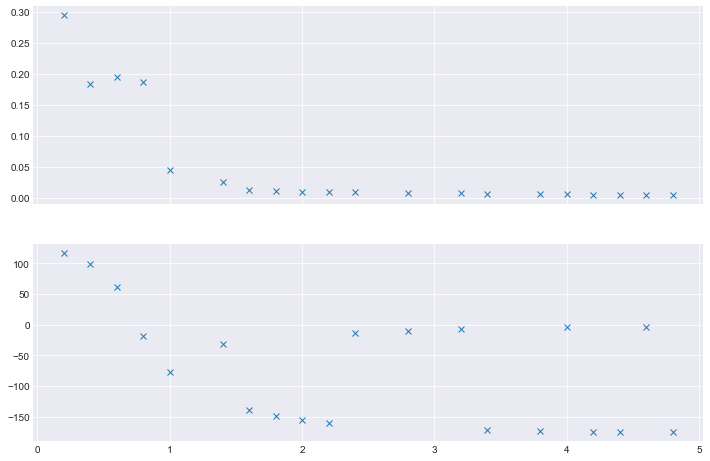

In [4]:
plt.close('all')

_, A, B = benchmark_state_space_vs_speed(*benchmark_matrices(), [5])
A = A[0]
B = B[0]
Bi = B[:, [1]] # steer torque
Ci = np.array([[1, 0, 0, 0]])
D = np.array([[0]])

sys = scipy.signal.StateSpace(A, Bi, Ci, D)
tf = scipy.signal.TransferFunction(sys)
_, y, _ = scipy.signal.lsim(tf, u, t)
        
x = np.fft.fft(y)/np.fft.fft(u)
freq = np.fft.fftfreq(t.shape[-1], t[1] - t[0])
index = [i for i, f in enumerate(freq) if f in u_freq]
print(freq[index])

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(freq[index], np.abs(x[index]), 'x')
ax[1].plot(freq[index], np.angle(x[index], deg=True), 'x')
plt.show()

In [5]:
def plot_response(log):
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(log.t,
               log.records.input[:, 1],
               label='steer torque')
    ax[0].plot(log.t,
               ps.get_kollmorgen_command_torque(
                   log.records.actuators.kollmorgen_command_velocity),
               label='commanded motor torque')
    ax[0].legend()
    ax[0].set_ylabel('torque [N-m]')
    
    encoder_angle = log.records.sensors.steer_encoder_count * 2*np.pi/152000
    encoder_angle[np.where(encoder_angle > np.pi)[0]] -= 2*np.pi
    ax[1].plot(log.t,
               log.states[:, 1],
               label='target encoder angle')
    ax[1].plot(log.t,
               encoder_angle,
               label='measured encoder angle')
    ax[1].legend()
    ax[1].set_ylabel('rad [s]')
    ax[1].set_xlabel('time [s]')
    return fig, ax